# Monte Carlo EM for Time Series Anomaly Detection Demo Notebook


In this notebook we demonstrate the method presented in the paper Monte Carlo EM for Deep Time Series Anomaly Detection, which was presented at the ICML 2021 Time Series Workshop. We present the pytorch implementation of the method in the paper as well as a demonstration on a simple toy example.

Time series data are often corrupted by outliers or other kinds of anomalies. Identifying the anomalous points can be a goal on its own (anomaly detection), or a means to improving performance of other time series tasks (e.g.\ forecasting). Recent deep-learning-based approaches to anomaly detection and forecasting commonly assume that the proportion of anomalies in the training data is small enough to ignore, and treat the  unlabeled data as coming from the nominal data distribution. We present a simple yet effective technique for augmenting existing time series models so that they explicitly account for anomalies in the training data. By augmenting the training data with a latent anomaly indicator variable whose distribution is inferred while training the underlying model using Monte Carlo EM, our method simultaneously infers anomalous points while improving model performance on nominal data. We demonstrate the effectiveness of the approach by combining it with a simple feed-forward forecasting model.


In this notebook we do not only show the method presented in the paper but also training methods that lead there. For each of the method we show a live plot of the output of the model through the training procedure.
The notebook is structured as follows:
- Creation of the dataset and the time series model
- Training approach 0: simply using the prediction error to do masking
- Training approach 1: Modeling the anomaly distribution with a mixture model
- Training approach 2: Modeling the anomaly distribution with a Hidden Markov Model



In [50]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import torch
import time

from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Creation of the dataset and the time series model

### Creation of a synthetic toy dataset

To demonstrate the approach, we create a synthetic time series composed of a sin wave with Gaussian noise where we add anomalies.

In [51]:
# Creating the dataset:

dataset_length = 1000
dataset_fraction_anomalies = 0.03


# creating the normal data:
y_values = np.cos(np.arange(dataset_length) / 10) * 0.4 + np.random.randn(dataset_length) / 15.0


# Injecting anomalies:
number_anomalies = np.int(dataset_length * dataset_fraction_anomalies)

anomalous_indices = np.random.choice(np.arange(0,dataset_length), number_anomalies, False)

y_values[anomalous_indices] += 2

# in addition to the single anomalous points, we create a longer anomaly
y_values[250:270] -= 2

all_anomalous_indices = list(anomalous_indices) + list(range(250,271))

<IPython.core.display.Javascript object>


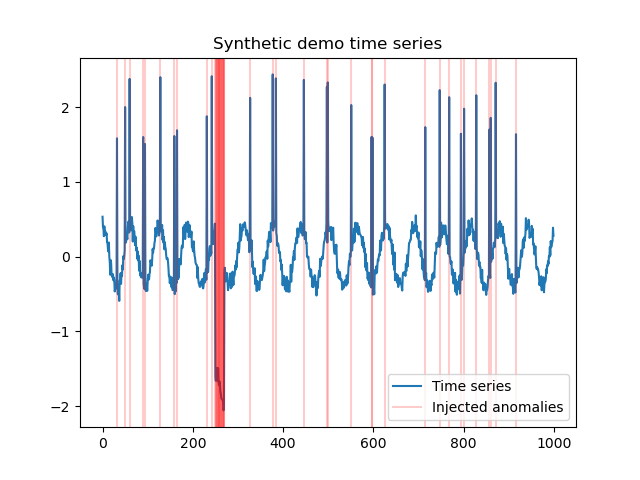

In [52]:
figure = plt.figure()
plt.plot(y_values)
for anomalous_index in all_anomalous_indices:
    plt.axvline(x=anomalous_index, color='red', alpha=0.2)
plt.title("Synthetic demo time series")
plt.legend(["Time series", "Injected anomalies"])

### The MLP implementation used

We create a simple MLP which can be used for (probabilistic) forecasting. As is common in anomaly detection, the idea is to train to model as a forecasting model and when deployed if the observed point is too unlikely under the predictive distribution it would be flagged as anomalous.


In [53]:

# Creating our model (super simple model):
def append_layer(l_layers, input_dimension, output_dimension):
    
    linear = torch.nn.Linear(input_dimension, output_dimension)
    l_layers.append(torch.nn.utils.weight_norm(linear))
    l_layers.append(torch.nn.LeakyReLU())
    
    return l_layers

class SimpleRegressionNN(torch.nn.Module):
    
    def __init__(self,
                input_dimension: int = 2,
                output_dimension: int = 2,
                hidden_dimension: int = 2,
                number_hidden: int = 2,
                ):
        
        super(SimpleRegressionNN, self).__init__()
        
        assert hidden_dimension > 0
        
        # Creating the network:
        net_layers = []
        
        net_layers = append_layer(net_layers, input_dimension, hidden_dimension)

        for i in range(number_hidden - 1):
            net_layers = append_layer(net_layers, hidden_dimension, hidden_dimension)

        net_layers.append(torch.nn.Linear(hidden_dimension, output_dimension))
        self.network = torch.nn.Sequential( *net_layers )

    def forward(self, x):
        return self.network(x)


In [54]:

# The dataset object that is used for all the training approaches

def get_windows(input_ts, context_length):
    
    list_windows = []
    
    for i in range(dataset_length - context_length):
        
        train_input = inputs[i:i+context_length]
        list_windows.append(train_input.unsqueeze(0))
    
    return torch.cat(list_windows, 0)


from torch.utils.data import Dataset, DataLoader

class WindowsDataset(Dataset):
    
    def __init__(self, input_ts, output_ts, masks_ts, context_length):
        self.input_ts = input_ts
        self.output_ts = output_ts
        self.masks_ts = masks_ts
        self.context_length = context_length
        if len(input_ts) != len(output_ts):
            raise Exception("The length of input does not match the length of output")

    def __len__(self):
        return len(self.input_ts)

    def __getitem__(self, index):
        
        if index < self.context_length:
            input_window = torch.cat([torch.zeros(context_length-index).to(device), self.input_ts[0:index]], 0)
        else:
            input_window = self.input_ts[index-context_length:index]
        target = self.output_ts[index]
        mask = self.masks_ts[index]
        
        return input_window, target, mask, index



In [55]:
# Defining the model and training hyper parameters that are common accross the three training approaches

# We make the MLP big enough so that it could fit the anomalies, but thanks to our method won't
context_length = 25
hidden_dimension = 16
number_hidden = 9

learning_rate = 0.00005
weight_decay = 1e-6



## Training approach 0: simply using the prediction error to do masking

The most simple way that one can think of to mask the anomalous points during training is simply by masking the points that have a high prediction error, this is what we do in this first approach. We simply train the network, and at each epoch we mask the k points that had the highest prediction error at the last training epoch. This approach is very simple and quite far from the better method that we present in the paper, but we believe that it can be helpful to understand the principle.

Two important aspects of the method that are already present here:
- the network is not trained to predict the points that are marked as anomalous, as a result these don't bias the model training away from the basic behaviour from the time series,
- we replace the points that are marked as anomalous in the input of the model. Here we simply replace them with the previous point. Later we replace them with the prediciton of the model for these time steps at the previous epoch, as it models the latent normal behaviour of the time series.



In [71]:

n_epochs = 5000

verbose = True

output_dimension = 1

model = SimpleRegressionNN(context_length, output_dimension, hidden_dimension, number_hidden)

number_masked_points = 40

<IPython.core.display.Javascript object>


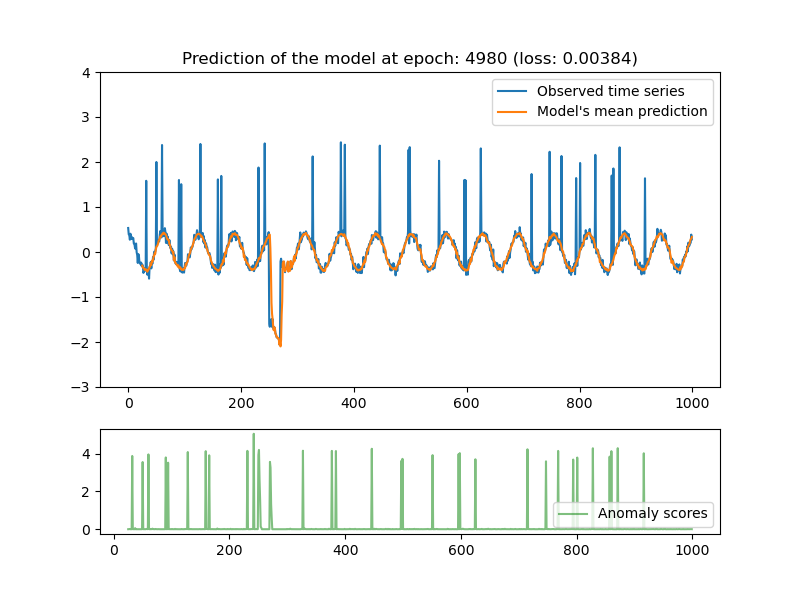

In [72]:

# We setup the plot to visualize the prediction of the network as training progresses
if verbose:
    fig, axarr = plt.subplots(2, 1, gridspec_kw = {'wspace':0, 'hspace':0.2, 'height_ratios':[3,1]}, figsize=(8,6))
    ax_1, ax_2 = axarr
    plt.ion()
    fig.show()
    fig.canvas.draw()

    
# Defining the optimizer:
parameters = list(model.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

model.train()
model.double().to(device)

# in this array we save the anomaly score predicted by the model for each of the time series point
#  we initialise it at random and it is overwitten in the first epoch
anomalous_scores = torch.from_numpy( np.random.randn(dataset_length - context_length).astype(np.double)).to(device)


for epoch in range(n_epochs):

    ## Masking per epoch:
    # We get the input and output time series:
    inputs = torch.from_numpy(y_values.astype(np.double)).to(device)
    outputs = inputs[context_length:].clone()
    
    # We get the time steps with the highest anomalous score
    topk_errors, topk_indices = torch.topk(anomalous_scores, number_masked_points)
    
    # We replace these time steps in the input time series with the previous time step
    inputs[topk_indices + context_length] = inputs[topk_indices - 1 + context_length]
    
    ## Normal training:
    windows = get_windows(inputs, context_length)
    
    pred_output = model(windows)
    
    losses = torch.square(pred_output.squeeze() - outputs)
        
    anomalous_scores = losses.clone()

    # We mask the loss of the points that are deemed to be anomalous
    losses[topk_indices] = 0.0
    loss = torch.mean(losses)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    predictions = pred_output
        
    # We visualise the current prediction of the network
    if verbose and epoch % 20 == 0:

        ax_1.clear()
        ax_2.clear()
        ax_1.plot(range(len(y_values)), y_values, label="Observed time series")

        targets_pred = predictions.cpu().detach().numpy()
        ax_1.plot(np.arange(len(targets_pred)) + context_length, targets_pred, label="Model's mean prediction")

        ploting_scores = anomalous_scores.cpu().detach().numpy()
        ax_2.plot(np.arange(len(ploting_scores)) + context_length, ploting_scores, color='green', alpha=0.5, label="Anomaly scores")
        
        ax_1.set_ylim([-3, 4])

        ax_1.legend()
        ax_2.legend()
        
        ax_1.set_title(f"Prediction of the model at epoch: {epoch} (loss: {loss.cpu().detach().numpy():.5f})")
        fig.canvas.draw()



As we can see, this training method already works pretty effectively but it has few issues. First, we have to pre-specify the number of points to be ignored, or set a threshold on the anomaly score before we start the training. Second, the replacement of the masked points is not very principled and has limitations for longer anomalies. Finally, once a point is flagged as anomalous it is ignored in training so it may never be seen as normal again, even if it might have been a mistake to flag it as anomalous. We address these problems with the next approach.


## Training approach 1: Modeling the anomaly distribution with a mixture model


We improve on the previous approach by modeling the time series as a mixture distribution. Each time step $x_t$ is drawn from the mixture distibution $p(x_t) = \alpha p^{+}(x_t) + (1-\alpha)p^{-}(x_t)$, where $p^{+}(x_t)$ is the distribution of the nominal data and $p^{-}(x_t)$ the anomalous data distribution (See more details in the background section of the paper).

Here we use the MLP presented above to model $p^{+}(x_t)$. We simply use it to parametrise a Gaussian distribution over the next time step given the context input points. And we use a uniform to model $p^{-}(x_t)$. As presented in the paper, one can also formulate this generatively: first, draw $y^+ \sim p^+(\cdot)$, $y^- \sim p^-(\cdot)$, and $z \sim \text{Bernoulli}(1-\alpha)$, and then set $x = \mathbf{I}[z=0] \, y^+ + \mathbf{I}[z=1] \, y^-$, i.e.\ the observation $x$ is equal to $y^+$ if it is nominal ($z=1$) and equal to $y^-$ otherwise. 

In the following implementation, in each epoch we take Monte Carlo samples from our posterior over $z$ for each of the time steps. Each sample gives us a set of time steps that are seen as anomalous and the others that are seen as normal. We mask the loss of the anomalous ones, and replace them in the input to the predictive model, by the prediction of the model at the last epoch.



In [58]:

n_epochs = 25

verbose = True

output_dimension = 2

proba_model = SimpleRegressionNN(context_length, output_dimension, hidden_dimension, number_hidden) # just doing a Gaussian for now

prior_probability_of_anomalous = 0.03

number_warm_up_epochs = 5
batch_size = 25

number_of_samples_from_posterior = 20


In [59]:
# getting the probability of any anomalous point (if we assume that the uniform distribution is uniform)

probability_y_under_M_minus = 1.0 / (np.nanmax(y_values) - np.nanmin(y_values))
probability_y_under_M_minus

0.22251545837876682

<IPython.core.display.Javascript object>


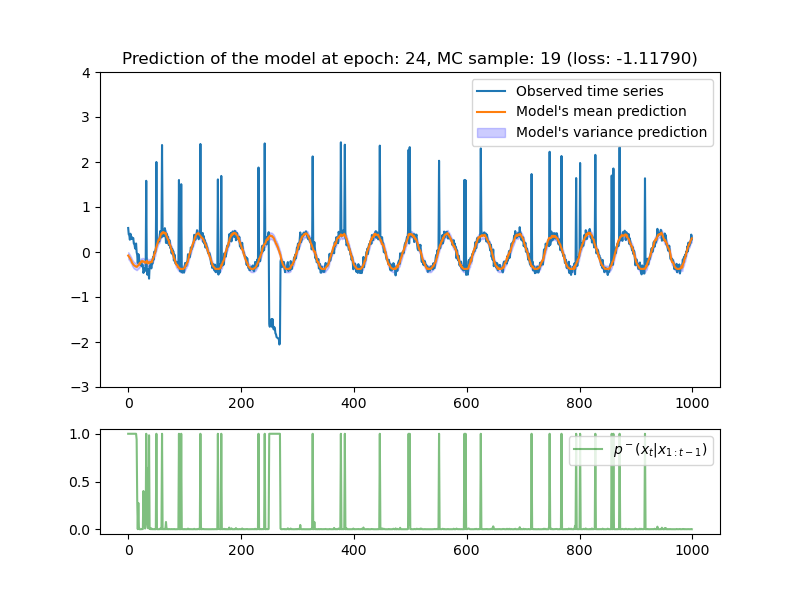

In [60]:

# We setup the plot to visualize the prediction of the network as training progresses
if verbose:
    fig, axarr = plt.subplots(2, 1, gridspec_kw = {'wspace':0, 'hspace':0.2, 'height_ratios':[3,1]}, figsize=(8,6))
    ax_1, ax_2 = axarr
    plt.ion()
    fig.show()
    fig.canvas.draw()

# Defining the optimizer:
parameters = list(proba_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

proba_model.train()
proba_model.double().to(device)

# We initialise here variables
probability_y_under_M_plus = torch.from_numpy( np.random.rand(dataset_length).astype(np.double) / 2).to(device)
pred_mean_whole_dataset = torch.from_numpy( np.random.randn(dataset_length).astype(np.double)).to(device)


for epoch in range(n_epochs):
    
    ## Getting the posterior probability of the points coming from M- (the model of anomalous data)
    sim_prob_M_plus_given_y = probability_y_under_M_plus * (1 - prior_probability_of_anomalous)
    sim_prob_M_minus_given_y = torch.ones_like(probability_y_under_M_plus) * probability_y_under_M_minus * prior_probability_of_anomalous
    
    # Simply using Bayse rule we obtain:
    prob_M_minus_given_y = sim_prob_M_minus_given_y / (sim_prob_M_minus_given_y + sim_prob_M_plus_given_y)
     
    # For the first few epochs we use prior probability of a point being anomalous
    if epoch < number_warm_up_epochs:
        prob_M_minus_given_y = torch.ones_like(probability_y_under_M_plus) * prior_probability_of_anomalous
    
    # Tensors to save the infered values for the whole dataset
    samples_probability_y_under_M_plus = torch.ones(number_of_samples_from_posterior, dataset_length)
    samples_pred_mean_whole_dataset = torch.ones(number_of_samples_from_posterior, dataset_length)
    samples_pred_var_whole_dataset = torch.ones(number_of_samples_from_posterior, dataset_length)
    
    
    for i_sample in range(number_of_samples_from_posterior):
        
        ## Here we take a sample from the posterior of the points being anomalous given the data and current model
        # we obtain a set of indicator variable distribution
        random_array = torch.from_numpy( np.random.rand(dataset_length).astype(np.double)).to(device)
        indices_from_M_minus = (random_array < prob_M_minus_given_y)
        masks_ts = indices_from_M_minus

        inputs = torch.from_numpy(y_values.astype(np.double)).to(device)
        outputs = inputs.clone()

        inputs[masks_ts] = pred_mean_whole_dataset.clone().detach().to(device)[masks_ts]

        # Creating the data loader:
        loader = iter(DataLoader(WindowsDataset(inputs, outputs, masks_ts, context_length), batch_size=batch_size, shuffle=True))

        # Tensors to save the infered values for the whole dataset
        probability_y_under_M_plus = torch.ones(dataset_length, dtype=torch.double, device=device)
        pred_mean_whole_dataset = torch.ones(dataset_length, dtype=torch.double, device=device)
        pred_var_whole_dataset = torch.ones(dataset_length, dtype=torch.double, device=device)

        # Go through all the batches:
        train_losses = []
        for i in range(0, dataset_length // batch_size):
            # Getting the training examples:
            windows, outputs, masks, indices = loader.next()

            pred_mean_and_var = proba_model(windows)

            pred_mean = pred_mean_and_var[:,0]
            pred_var = torch.square(pred_mean_and_var[:,1])

            out_distr = torch.distributions.normal.Normal(pred_mean, pred_var)

            losses = -1 * out_distr.log_prob(outputs)

            # save info on the whole dataset:
            probability_y_under_M_plus[indices] = torch.exp(-1 * losses.clone())
            pred_mean_whole_dataset[indices] = pred_mean.clone()
            pred_var_whole_dataset[indices] = pred_var.clone()

            # We mask the loss of the points that are deemed to be anomalous
            losses[masks] = 0.0
            loss = torch.mean(losses)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.cpu().detach().numpy())
    
        # We save the predictions in this MC sample
        samples_probability_y_under_M_plus[i_sample,:] = probability_y_under_M_plus 
        samples_pred_mean_whole_dataset[i_sample,:] = pred_mean_whole_dataset
        samples_pred_var_whole_dataset[i_sample,:] = pred_var_whole_dataset
    
    
        # If wanted we plot the current state of the prediction of the algorithm
        if verbose:

            ax_1.clear()
            ax_2.clear()
            ax_1.plot(range(len(y_values)), y_values, label="Observed time series")

            targets_pred = pred_mean_whole_dataset.cpu().detach().numpy()
            ax_1.plot(np.arange(len(targets_pred)), targets_pred, label="Model's mean prediction")

            target_var = pred_var_whole_dataset.cpu().detach().numpy()
            ax_1.fill_between(np.arange(len(targets_pred)), targets_pred-target_var,  targets_pred+target_var, color='b', alpha=0.2, label="Model's variance prediction")

            ploting_scores = prob_M_minus_given_y.cpu().detach().numpy()
            ax_2.plot(np.arange(len(ploting_scores)), ploting_scores, color='green', alpha=0.5, label="$p^-(x_t|x_{1:t-1})$")

            ax_1.set_ylim([-3, 4])
            
            ax_1.legend()
            ax_2.legend()

            ax_1.set_title(f"Prediction of the model at epoch: {epoch}, MC sample: {i_sample} (loss: {np.mean(train_losses):.5f})")
            fig.canvas.draw()

    # Averaging over the MC samples:
    probability_y_under_M_plus = torch.mean(samples_probability_y_under_M_plus, 0).to(device).double()
    pred_mean_whole_dataset = torch.mean(samples_pred_mean_whole_dataset, 0).to(device).double()
    pred_var_whole_dataset = torch.mean(samples_pred_var_whole_dataset, 0).to(device).double()
    
    





As we can see, this works as expected and we are able to both fit the model and infer the anomalous data points quite confidently. This is great and this is very close to the method presented in the paper. There is one last missing piece: we are modeling the probability of a point being anomalous or not idenpendently for each time step, whereas in general anomalies may last for multiple time steps, in which case a point should be more likely to be anomalous given that the previous time step is anomalous.
In general on a given problem, one may also have a prior belief on likely anomalous points are to follow each other, and we would also want to model this.




## Training approach 2: Modeling the anomaly distribution with a Hidden Markov Model


To address the issue of the previous approach we use a Hidden Markov Model (HMM) to model the distribution of indicator variables $z$. We model the time series of indicator variables with and HMM with two states: normal and anomalous. We have a transition metrix giving the probabilities to transition from one state to another, which is updated in the M-step of the HMM. We infer the posterior distribution over the indicator variables using the E-step of the HMM.

This is the method presented in the paper, the code is a bit long because the E-step and M-step of the HMM are shown explicitly, appart from these additions the code is vewry similar to the mixture model approach. Hopefully with the help of the first two approaches and the comments the code should be understandable.



In [61]:

n_epochs = 25

verbose = True

output_dimension = 2

proba_model = SimpleRegressionNN(context_length, output_dimension, hidden_dimension, number_hidden) 

prior_probability_of_anomalous = 0.03

number_warm_up_epochs = 5
batch_size = 25

number_of_samples_from_posterior = 20



In [62]:

probability_y_under_M_minus = 1.0 / (np.nanmax(y_values) - np.nanmin(y_values))
probability_y_under_M_minus

0.22251545837876682

<IPython.core.display.Javascript object>


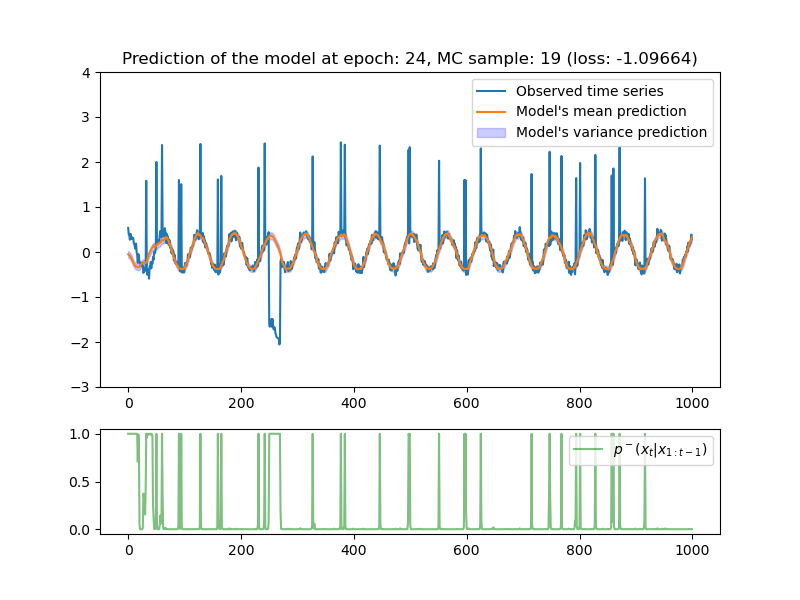

prob_from_anom_to_norm 0.38477607107431
prob_from_anom_to_anom 0.6152238713475371
prob_from_norm_to_anom 0.035546467860527564
prob_from_norm_to_norm 0.9644535321394725


In [63]:


# We setup the plot to visualize the prediction of the network as training progresses
if verbose:
    fig, axarr = plt.subplots(2, 1, gridspec_kw = {'wspace':0, 'hspace':0.2, 'height_ratios':[3,1]}, figsize=(8,6))
    ax_1, ax_2 = axarr
    plt.ion()
    fig.show()
    fig.canvas.draw()


# Defining the optimizer:
parameters = list(proba_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

proba_model.train()
proba_model.double().to(device)


probability_y_under_M_plus = torch.from_numpy( np.random.rand(dataset_length).astype(np.double) / 2).to(device)
pred_mean_whole_dataset = torch.from_numpy( np.random.randn(dataset_length).astype(np.double)).to(device)


### Definition of the HMM:
prob_from_anom_to_norm = 0.98
prob_from_anom_to_anom = 1 - prob_from_anom_to_norm

prob_from_norm_to_anom = 0.05
prob_from_norm_to_norm = 1 - prob_from_norm_to_anom

moving_average_remembering_previous_transitions = 0.5


for epoch in range(n_epochs):
    
    #p(M+ | D) = (p(D | M+) p(M+)) / p(D)
    
    ## Getting the posterior probability of the points coming from M- (the model of anomalous data)
    sim_prob_M_plus_given_y = probability_y_under_M_plus * (1 - prior_probability_of_anomalous)
    sim_prob_M_minus_given_y = torch.ones_like(probability_y_under_M_plus) * probability_y_under_M_minus * prior_probability_of_anomalous
    
    prob_data = (sim_prob_M_minus_given_y + sim_prob_M_plus_given_y)
    
    prob_M_minus_given_y = sim_prob_M_minus_given_y / prob_data
    
    
    ## HMM E-step:
    #   Over the next few lines we perform the E-step of the HMM, where we infer the posterior 
    #    on the state probabilities using the standard filtering and smoothing using the alpha and beta messages.
    alpha_filtering_messages = torch.ones([dataset_length, 2], device=device)
    beta_smoothing_messages = torch.ones([dataset_length, 2], device=device)
    
    alpha_filtering_messages[0, 0] = 1 - prob_M_minus_given_y[0]
    alpha_filtering_messages[0, 1] = prob_M_minus_given_y[0]
    
    # Doing the filtering going through each of the time steps:
    for t in range(1, probability_y_under_M_plus.shape[0]):
        
        ### Getting minus first:
        s_t_prev_zero = alpha_filtering_messages[t-1, 0] * prob_from_norm_to_anom
        s_t_prev_one = alpha_filtering_messages[t-1, 1] * prob_from_anom_to_anom
        
        minus_prior_for_time_point = (s_t_prev_zero + s_t_prev_one)
        alpha_filtering_messages[t, 1] = probability_y_under_M_minus * minus_prior_for_time_point
        
        ### Then plus:
        s_t_prev_zero = alpha_filtering_messages[t-1, 0] * prob_from_norm_to_norm
        s_t_prev_one = alpha_filtering_messages[t-1, 1] * prob_from_anom_to_norm
        
        plus_prior_for_time_point = (s_t_prev_zero + s_t_prev_one)
        alpha_filtering_messages[t, 0]  = probability_y_under_M_plus[t] * plus_prior_for_time_point
        
        # normalising to not have too small numbers (could use log but not sure)
        sum_norm_anom = alpha_filtering_messages[t, 0] + alpha_filtering_messages[t, 1]
        alpha_filtering_messages[t, 0] *= 1 / sum_norm_anom
        alpha_filtering_messages[t, 1] *= 1 / sum_norm_anom
        
    beta_smoothing_messages[-1, 0] = 1
    beta_smoothing_messages[-1, 1] = 1
    
    for t in range(probability_y_under_M_plus.shape[0] - 2,0,-1):
        
        p_y_t_norm_times_beta_t_norm = probability_y_under_M_plus[t+1] * beta_smoothing_messages[t+1, 0]
        p_y_t_anom_times_beta_t_anom = probability_y_under_M_minus * beta_smoothing_messages[t+1, 1]
        
        ### Getting minus first:
        beta_smoothing_messages[t, 1] = p_y_t_norm_times_beta_t_norm * prob_from_anom_to_norm + p_y_t_anom_times_beta_t_anom * prob_from_anom_to_anom
        
        ### Then plus:
        beta_smoothing_messages[t, 0] = p_y_t_norm_times_beta_t_norm * prob_from_norm_to_norm + p_y_t_anom_times_beta_t_anom * prob_from_norm_to_anom
        
        # normalising to not have too small numbers (could use log but not sure)
        sum_norm_anom = beta_smoothing_messages[t, 0] + beta_smoothing_messages[t, 1]
        beta_smoothing_messages[t, 0] *= 1 / sum_norm_anom
        beta_smoothing_messages[t, 1] *= 1 / sum_norm_anom
        
    alpha_beta_norm = beta_smoothing_messages[:,0] * alpha_filtering_messages[:, 0]
    alpha_beta_anom = beta_smoothing_messages[:,1] * alpha_filtering_messages[:, 1]
    
    prob_M_minus_given_y = alpha_beta_anom / (alpha_beta_norm + alpha_beta_anom)
    
    ### This is the end of the E-step of the HMM
    

    # For the first few epochs we use prior probability of a point being anomalous
    if epoch < number_warm_up_epochs:
        prob_M_minus_given_y = torch.ones_like(probability_y_under_M_plus) * prior_probability_of_anomalous
    
    
    # Tensors to save the infered values for the whole dataset
    samples_probability_y_under_M_plus = torch.ones(number_of_samples_from_posterior, dataset_length)
    samples_pred_mean_whole_dataset = torch.ones(number_of_samples_from_posterior, dataset_length)
    samples_pred_var_whole_dataset = torch.ones(number_of_samples_from_posterior, dataset_length)
    samples_indices_whole_dataset = torch.ones(number_of_samples_from_posterior, dataset_length)
    
    
    for i_sample in range(number_of_samples_from_posterior):
    
        ## Here we take a sample from the posterior of the points being anomalous given the data and current model
        # we obtain a set of indicator variable distribution
        random_array = torch.from_numpy( np.random.rand(dataset_length).astype(np.double)).to(device)

        indices_from_M_minus = (random_array < prob_M_minus_given_y)
        masks_ts = indices_from_M_minus
        
        samples_indices_whole_dataset[i_sample,:] = indices_from_M_minus

        inputs = torch.from_numpy(y_values.astype(np.double)).to(device)
        outputs = inputs.clone()
        
        inputs[masks_ts] = pred_mean_whole_dataset.clone().detach().to(device)[masks_ts]

        loader = iter(DataLoader(WindowsDataset(inputs, outputs, masks_ts, context_length), batch_size=batch_size, shuffle=True))

        # Tensors to save the infered values for the whole dataset
        probability_y_under_M_plus = torch.ones(dataset_length, dtype=torch.double, device=device)
        pred_mean_whole_dataset = torch.ones(dataset_length, dtype=torch.double, device=device)
        pred_var_whole_dataset = torch.ones(dataset_length, dtype=torch.double, device=device)

        # Go through all the batches:
        train_losses = []
        for i in range(0, dataset_length // batch_size):
            # Getting the training examples:
            windows, outputs, masks, indices = loader.next()

            pred_mean_and_var = proba_model(windows)

            pred_mean = pred_mean_and_var[:,0]
            pred_var = torch.square(pred_mean_and_var[:,1])

            out_distr = torch.distributions.normal.Normal(pred_mean, pred_var)

            losses = -1 * out_distr.log_prob(outputs)

            # save info on the whole dataset:
            probability_y_under_M_plus[indices] = torch.exp(-1 * losses.clone())
            pred_mean_whole_dataset[indices] = pred_mean.clone()
            pred_var_whole_dataset[indices] = pred_var.clone()

            # Do the training:
            losses[masks] = 0.0
            loss = torch.mean(losses)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.cpu().detach().numpy())
    
        samples_probability_y_under_M_plus[i_sample,:] = probability_y_under_M_plus 
        samples_pred_mean_whole_dataset[i_sample,:] = pred_mean_whole_dataset
        samples_pred_var_whole_dataset[i_sample,:] = pred_var_whole_dataset
        
        # If wanted we plot the current state of the prediction of the algorithm
        if verbose:
            ax_1.clear()
            ax_2.clear()
            
            ax_1.plot(range(len(y_values)), y_values, label="Observed time series")

            targets_pred = pred_mean_whole_dataset.cpu().detach().numpy()
            ax_1.plot(np.arange(len(targets_pred)), targets_pred, label="Model's mean prediction")

            target_var = pred_var_whole_dataset.cpu().detach().numpy()
            ax_1.fill_between(np.arange(len(targets_pred)), targets_pred-target_var,  targets_pred+target_var, color='b', alpha=0.2, label="Model's variance prediction")

            ploting_scores = prob_M_minus_given_y.cpu().detach().numpy()
            ax_2.plot(np.arange(len(ploting_scores)), ploting_scores, color='green', alpha=0.5, label="$p^-(x_t|x_{1:t-1})$")

            ax_1.set_ylim([-3, 4])
            
            ax_1.legend()
            ax_2.legend()

            ax_1.set_title(f"Prediction of the model at epoch: {epoch}, MC sample: {i_sample} (loss: {np.mean(train_losses):.5f})")
            fig.canvas.draw()

    # Averaging over the samples:
    probability_y_under_M_plus = torch.mean(samples_probability_y_under_M_plus, 0).to(device).double()
    pred_mean_whole_dataset = torch.mean(samples_pred_mean_whole_dataset, 0).to(device).double()
    pred_var_whole_dataset = torch.mean(samples_pred_var_whole_dataset, 0).to(device).double()

    #### M-step of the HMM:
    counter_from_anom_to_norm = 0
    counter_from_anom_to_anom = 0
    counter_from_norm_to_anom = 0
    counter_from_norm_to_norm = 0
    
    for i_sample in range(number_of_samples_from_posterior):
        for t in range(dataset_length-1):
            
            this_t = samples_indices_whole_dataset[i_sample, t]
            next_t = samples_indices_whole_dataset[i_sample, t+1]
            
            if this_t == 1:
                if next_t == 1:
                    counter_from_anom_to_anom += 1
                else:
                    counter_from_anom_to_norm += 1
            else:
                if next_t == 1:
                    counter_from_norm_to_anom += 1
                else:
                    counter_from_norm_to_norm += 1
    
    new_prob_anom_to_anom = counter_from_anom_to_anom / (counter_from_anom_to_anom + counter_from_anom_to_norm + 1e-4)
    new_prob_anom_to_norm = counter_from_anom_to_norm / (counter_from_anom_to_anom + counter_from_anom_to_norm + 1e-4)
    
    new_prob_norm_to_anom = counter_from_norm_to_anom / (counter_from_norm_to_anom + counter_from_norm_to_norm)
    new_prob_norm_to_norm = counter_from_norm_to_norm / (counter_from_norm_to_anom + counter_from_norm_to_norm)
    
    param_avr = moving_average_remembering_previous_transitions
    prob_from_anom_to_norm = (1 - param_avr) * new_prob_anom_to_norm + param_avr * prob_from_anom_to_norm
    prob_from_anom_to_anom = (1 - param_avr) * new_prob_anom_to_anom + param_avr * prob_from_anom_to_anom

    prob_from_norm_to_anom = (1 - param_avr) * new_prob_norm_to_anom + param_avr * prob_from_norm_to_anom
    prob_from_norm_to_norm = (1 - param_avr) * new_prob_norm_to_norm + param_avr * prob_from_norm_to_norm

    ### End of the M-step of the HMM
    
print("prob_from_anom_to_norm", prob_from_anom_to_norm)
print("prob_from_anom_to_anom", prob_from_anom_to_anom)
print("prob_from_norm_to_anom", prob_from_norm_to_anom)
print("prob_from_norm_to_norm", prob_from_norm_to_norm)

